In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
import datetime
import json

import matplotlib.pyplot as plt

In [2]:
def parse_if_number(s):
    try:
        return float(s)
    except:
        return True if s == "true" else False if s == "false" else s if s else None

In [3]:
def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

In [4]:
def parse_vectime_vecvalue(df):

    new_df = pd.DataFrame(columns=["Node", "Name", "Time", "Value"])

    names = []
    nodes = []

    count = 1

    print("Parsing vector file")

    vectimes = np.array([])
    vecvalues = np.array([])

    df_len = len(df.index)

    for index, row in df.iterrows():
        names.append([row[2] for _ in range(len(row.vectime))])
        nodes.append([row.node for _ in range(len(row.vectime))])
        vectimes = np.concatenate((vectimes, row.vectime))
        vecvalues = np.concatenate((vecvalues, row.vecvalue))

        print("Processed row: {} of {}".format(count, df_len))
        count += 1
        break

    new_df = new_df.append({"Node": nodes, "Name": names, "Time": vectimes, "Value": vecvalues}, ignore_index=True)

    return new_df

In [5]:
def create_bins(lower_bound, width, quantity):
    """ create_bins returns an equal-width (distance) partitioning. 
        It returns an ascending list of tuples, representing the intervals.
        A tuple bins[i], i.e. (bins[i][0], bins[i][1])  with i > 0 
        and i < quantity, satisfies the following conditions:
            (1) bins[i][0] + width == bins[i][1]
            (2) bins[i-1][0] + width == bins[i][0] and
                bins[i-1][1] + width == bins[i][1]
    """
    
    bins = []
    for low in range(lower_bound, 
                     lower_bound + quantity*width + 1, width):
        bins.append((low, low+width))
    return bins

In [31]:
raw_results = "/home/brian/results-analysis/data/raw_data/jakes-fading2.csv"
stats = "/home/brian/results-analysis/configs/mode4-stats.json"

In [32]:
raw_df = pd.read_csv(raw_results, converters={
        "attrvalue": parse_if_number,
        "binedges" : parse_ndarray,
        "binvalues": parse_ndarray,
        "vectime"  : parse_ndarray,
        "vecvalue" : parse_ndarray})

print("Loaded csv into DataFrame")

Loaded csv into DataFrame


In [33]:
# It's likely this will change depending on the run/system
# Might be worth investigating some form of alternative
broken_module = raw_df['module'].str.split('.', 3, expand=True)

raw_df["network"] = broken_module[0]
raw_df["node"] = broken_module[1]
raw_df["interface"] = broken_module[2]
raw_df["layer"] = broken_module[3]

raw_df = raw_df.drop("module", axis=1)

In [34]:
# Remove junk from common node names
raw_df.node = raw_df.node.str.replace("node", "")
raw_df.node = raw_df.node.str.replace("[", "")
raw_df.node = raw_df.node.str.replace("]", "")
raw_df.node = raw_df.node.str.replace("car", "")

In [35]:
if stats:
    with open(stats) as json_file:
        data = json.load(json_file)
        raw_df = raw_df[raw_df.name.isin(data["filtered_vectors"]) | raw_df.name.isin(data["filtered_scalars"])]
        raw_df = raw_df.reset_index(drop=True)        

In [36]:
# This will always remain the same for all runs.
broken_run = raw_df['run'].str.split('-', 4, expand=True)

raw_df["scenario"] = broken_run[0]
raw_df["run"] = broken_run[1]
raw_df["date"] = broken_run[2]
raw_df["time"] = broken_run[3]
raw_df["processId"] = broken_run[4]

In [37]:
runattr_df = raw_df[raw_df["type"] == "runattr"]
runattr_df = runattr_df.dropna(axis=1, how="all")
runattr_df = runattr_df.reset_index(drop=True)

In [38]:
itervar_df = raw_df[raw_df["type"] == "itervar"]
itervar_df = itervar_df.dropna(axis=1, how="all")
itervar_df = itervar_df.reset_index(drop=True)

In [39]:
param_df = raw_df[raw_df["type"] == "param"]
param_df = param_df.dropna(axis=1, how="all")
param_df = param_df.reset_index(drop=True)

In [40]:
attr_df = raw_df[raw_df["type"] == "attr"]
attr_df = attr_df.dropna(axis=1, how="all")
attr_df = attr_df.reset_index(drop=True)

In [41]:
scalar_df = raw_df[raw_df["type"] == "scalar"]
scalar_df = scalar_df.dropna(axis=1, how="all")
scalar_df = scalar_df.reset_index(drop=True)

In [42]:
vector_df = raw_df[raw_df["type"] == "vector"]
vector_df = vector_df.dropna(axis=1, how="all")
vector_df = vector_df.reset_index(drop=True)

### Different approach

In [43]:
rows_we_want = vector_df.drop(["run", "type", "network", "interface", "layer", "scenario", "date", "time", "processId"], axis=1)
rows_we_want = rows_we_want.reset_index(drop=True)

In [44]:
lst_col = "vectime"
vectime_split = pd.DataFrame({
    col:np.repeat(rows_we_want[col].values, rows_we_want[lst_col].str.len())
    for col in rows_we_want.columns.difference([lst_col])}).assign(**{lst_col:np.concatenate(rows_we_want[lst_col].values)})[rows_we_want.columns.tolist()]

In [45]:
lst_col = "vecvalue"
vecvalue_split = pd.DataFrame({
    col:np.repeat(rows_we_want[col].values, rows_we_want[lst_col].str.len())
    for col in rows_we_want.columns.difference([lst_col])}).assign(**{lst_col:np.concatenate(rows_we_want[lst_col].values)})[rows_we_want.columns.tolist()]

In [46]:
vecvalue_split["vectime"] = vectime_split["vectime"]

In [47]:
node_include_df = vecvalue_split

In [48]:
node_filtered_df = node_include_df[node_include_df["name"] == "txRxDistanceTB:vector"]

In [49]:
node_filtered_df = node_filtered_df.reset_index(drop=True)

In [50]:
received   = node_include_df[node_include_df["name"] == "tbsReceived:vector"]
failed_tb  = node_include_df[node_include_df["name"] == "tbFailedButSCIReceived:vector"]
failed_sci = node_include_df[node_include_df["name"] == "tbsFailedDueToNoSCI:vector"]

received = received.reset_index(drop=True)
failed_sci = failed_sci.reset_index(drop=True)
failed_tb = failed_tb.reset_index(drop=True)

In [51]:
merged_df = pd.DataFrame()
merged_df["time"] = received["vectime"]
merged_df["distance"] = node_filtered_df["vecvalue"]
merged_df["received"] = received["vecvalue"]
merged_df["failed_tb"] = failed_tb["vecvalue"]
merged_df["failed_sci"] = failed_sci["vecvalue"]
merged_df["node"] = node_filtered_df["node"]

In [52]:
merged_df["pdr"] = (merged_df["received"] - merged_df["failed_tb"] - merged_df["failed_sci"]/(merged_df["received"])) * 100

In [53]:
bins = create_bins(lower_bound=0, width=10, quantity=49)

In [54]:
distances = []
pdrs_highway_fast = []
for interval in bins:
    lower_b = interval[0]
    upper_b = interval[1]
    pdr_temp_highway_fast = merged_df[(merged_df["distance"] >= lower_b) & (merged_df["distance"] < upper_b)]
    pdrs_highway_fast.append(pdr_temp_highway_fast["pdr"].mean())
    distances.append(upper_b)

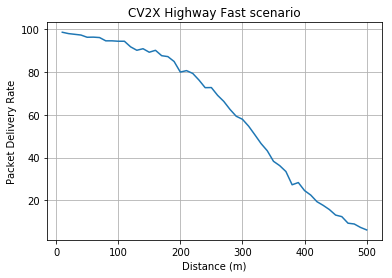

In [55]:
fig, ax = plt.subplots()
ax.plot(distances, pdrs_highway_fast)
ax.set(xlabel='Distance (m)', ylabel='Packet Delivery Rate',
       title='CV2X Highway Fast scenario')
ax.grid()

fig.savefig("figures/highway_fast-rand-interference.png")
plt.show()

### Average PRR

In [132]:
prr_df = merged_df

In [133]:
prr_df["notDecoded"] = prr_df["failed_tb"] + prr_df["failed_sci"]

In [134]:
prr_df = prr_df.drop(axis=1, columns=["failed_tb", "failed_sci"])

In [135]:
prr_df["prr"] = prr_df["received"] - prr_df["notDecoded"]

In [136]:
prr_df["node"] = pd.to_numeric(prr_df["node"])

In [137]:
bins = create_bins(lower_bound=0, width=20, quantity=25)

In [138]:
distances = []
prrs = []
for interval in bins:
    lower_b = interval[0]
    upper_b = interval[1]
    prr_temp = prr_df[(prr_df["distance"] >= lower_b) & (prr_df["distance"] < upper_b)]
    prrs.append(prr_temp["prr"].mean())
    distances.append(upper_b)

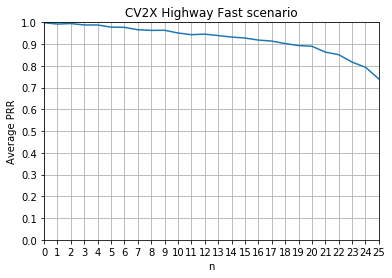

In [139]:
fig, ax = plt.subplots()
ax.plot(range(len(distances)), prrs)
ax.set(xlabel='n', ylabel='Average PRR',
       title='CV2X Highway Fast scenario')
ax.set_ylim([0,1])
ax.set_xlim([0,25])
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0,26, step=1))
ax.grid()

fig.savefig("figures/highway_fast_rand_interference2.svg")
plt.show()

### Finished fixing vector DF

In [ ]:
vector_df = parse_vectime_vecvalue(vector_df)

In [ ]:
now = datetime.datetime.now()
if args.name != now:
    directory = "{}/{}-{}".format(args.tidied_results, now.strftime("%Y-%m-%d_%H:%M"), args.name)
else:
    directory = "{}/{}".format(args.tidied_results, now.strftime("%Y-%m-%d_%H:%M"))

os.mkdir(directory)

runattr_df.to_csv("{}/{}".format(directory, "runattr.csv"), index=False)
itervar_df.to_csv("{}/{}".format(directory, "itervar.csv"), index=False)
param_df.to_csv("{}/{}".format(directory, "params.csv"), index=False)
attr_df.to_csv("{}/{}".format(directory, "attr.csv"), index=False)
vector_df.to_csv("{}/{}".format(directory, "vector.csv"), index=False)
scalar_df.to_csv("{}/{}".format(directory, "scalar.csv"), index=False)